In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

pd.set_option('display.max_columns', None)


In [3]:
data = pd.read_csv('PlusSupplementaryFeatures_041924.csv')
data2 = pd.read_csv('PollStar_KPop_cleaned_dataset.csv')
data3 = pd.read_csv('/Users/jefferysun/Desktop/A_Round_RnA/pollstar_sp_yt.csv')
df_10k = pd.read_csv('/Users/jefferysun/Desktop/A_Round_RnA/cleaned_data_allpop100k_usdemogr.csv')
df_10k = df_10k.drop('字段21', axis=1)
ref_ = pd.read_csv('/Users/jefferysun/Desktop/A_Round_RnA/artist_list_sp_yt.csv')
df_ap = pd.read_csv('/Users/jefferysun/Desktop/A_Round_RnA/Data_Collected/AsianPop_withFestival.csv')

In [16]:
df_ap.head()

,Event Date,Number of Shows,Headliner,Support,Venue,City,State,Country,Market,Company Type,Currency,Promoter,Genre,Avg. Tickets Sold,Avg. Gross USD,Avg. Event Capacity,Avg. Capacity Sold,Ticket Price Min,Ticket Price Max,Ticket Price Avg. USD,字段21
0,8/8/2024,1,Yoasobi,NaN,MGM Music Hall at Fenway,Boston,Massachusetts,United States,Boston (Manchester),Club,US DOLLAR,"(In-House Promotion), Crossroads Presents, Liv...",Asian Pop,"4,025","$324,474.00","4,025",100%,$32.00,$122.00,$80.61,NaN
1,8/6/2024,1,ATEEZ,NaN,Capital One Arena,Washington,District of Columbia,United States,"Washington, D.C. (Hagerstown)",Arena,US DOLLAR,AEG Presents,Asian Pop,"12,766","$2,662,071.08","13,055",97%,$64.50,$214.50,$208.53,NaN
2,8/6/2024,1,Yoasobi,NaN,Radio City Music Hall,New York,New York,United States,New York,Auditorium / Theatre,US DOLLAR,Live Nation,Asian Pop,"5,918","$595,106.88","5,918",100%,$49.50,$149.50,$100.56,NaN
3,8/5/2024,1,Chuu,NaN,The Town Hall,New York,New York,United States,New York,Auditorium / Theatre,US DOLLAR,(In-House Promotion),Asian Pop,680,"$69,766.70","1,429",47%,$30.00,$30.00,$102.60,NaN
4,8/5/2024,1,The Volunteers,NaN,Old National Centre,Indianapolis,Indiana,United States,Indianapolis,Complex,US DOLLAR,(In-House Promotion),Asian Pop,187,"$5,565.00","1,150",16%,$15.00,$143.50,$29.76,NaN


TypeError: sorted expected 1 argument, got 2

In [19]:
# Adding a popularity matrix

popularity_matrix = ['yt View Count',
                     'yt Subscriber Count',
                     'yt Video Count',
                     'sp followers']


# Define the weights for the popularity matrix

weight = {'yt View Count': 0.2,
          'yt Subscriber Count': 0.2,
          'yt Video Count': 0.2,
          'sp followers': 0.3}

In [142]:
ref_ = ref_[['Headliner'] + popularity_matrix]

In [143]:
ref_.loc[ref_.isna().any(axis=1)]

,Headliner,yt View Count,yt Subscriber Count,yt Video Count,sp followers
50,20 Fingers f. Nyah Jewel,NaN,NaN,NaN,511850


In [144]:
ref_.loc[50,'Headliner'] = '20 Fingers'

In [145]:
ref_.loc[50,'Headliner'] = '20 Fingers f. Nyah Jewel'
ref_.loc[50,'yt View Count'] = 9379572
ref_.loc[50,'yt Subscriber Count'] = 7730
ref_.loc[50,'yt Video Count'] = 55
ref_.loc[50,'sp followers'] = 532291 

In [146]:
# ref_ = ref_.drop('yt Video Count\t', axis = 1)
ref_

,Headliner,yt View Count,yt Subscriber Count,yt Video Count,sp followers
0,The Turtles,85692695.0,45600.0,691.0,620382
1,Jay and The Americans,46645.0,114.0,31.0,134533
2,The Association,10917.0,228.0,38.0,254309
3,Phillip-Michael Scales,247280.0,2700.0,49.0,11055
4,Dale and the ZDubs,280691.0,1200.0,81.0,7133
...,...,...,...,...,...
314,Gary Lewis & The Playboys,1257747.0,2600.0,301.0,150483
315,Chris Kroeze,985772.0,6200.0,111.0,6292
316,Tracey Blake,6032.0,201.0,11.0,337
317,Michael Bland,13557.0,273.0,15.0,34358


In [147]:
# Filtering out the multi-artist event data in the United States 
# Dropping NA from the column 'Support'

df_10k_ma = df_10k[df_10k['Headliner'].str.contains(r"['\"]") & (df_10k['Country']=='United States')].dropna(subset=['Support'])

data_ma = data[data['Headliner'].str.contains(r"['\"]") & (data['Country']=='United States')].dropna(subset=['Support'])

df_10k_ma.head()

,Unnamed: 0,Event Date,# Shows,Headliner,Support,Venue,City,State,Country,Market,Company Type,Currency,Promoter,Genre,Avg. Tickets Sold,Avg. Gross USD,Avg. Event Capacity,Avg. Capacity Sold,Ticket Price Min,Ticket Price Max,Ticket Price Avg. USD,sp artist_name,sp artist_genre,sp followers,sp popularity,yt name,yt Channel ID,yt Title,yt Description,yt Published At,yt View Count,yt Subscriber Count,yt Video Count,Location,Month,is_holiday,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,Total population,Under 5 years population,5 to 9 years population,10 to 14 years population,15 to 19 years population,20 to 24 years population,25 to 34 years population,35 to 44 years population,45 to 54 years population,55 to 59 years population,60 to 64 years population,65 to 74 years population,75 to 84 years population,85 years and over population,Median age
16,16,2024-06-02,1.0,"""The Happy Together Tour""","The Turtles, Jay and The Americans, The Associ...",Ruth Eckerd Hall,Clearwater,Florida,United States,Tampa-St. Petersburg,NaN,US DOLLAR,Ruth Eckerd Hall Presents,Pop / Rock,"2,024",112065.0,2024.0,100%,40.0,75.0,55.37,"""The Happy Together Tour""","['modern folk rock', 'new jersey indie', 'pov:...",211712.0,54.0,"""The Happy Together Tour""",UCUoKfHPq8vdyMUk0B-y1RPw,Linda Merion Karavokiros,Check out our other channel Miss Tabitha and F...,2011-06-27T15:50:59Z,31354.0,57.0,90.0,Clearwater_United States,6,False,0,0,0,0,0,1,116984,5588,5739,6402,5053,5970,15435,12819,15523,9122,7835,14995,7708,4795,46.0
33,33,2024-05-31,1.0,Keb' Mo',Phillip-Michael Scales,Sandler Center For The Performing Arts,Virginia Beach,Virginia,United States,Norfolk-Portsmouth-Newport,NaN,US DOLLAR,NS2,"Americana, Blues","1,056",71514.5,1282.0,82%,49.5,75.0,67.72,Keb' Mo',"['acoustic blues', 'blues', 'country blues', '...",358507.0,48.0,Keb' Mo',UCl9AgUauofjFUHMlOKd_K6Q,Keb' Mo',"The new album ""Oklahoma"" is now out! Oklahoma ...",2007-09-10T08:11:32Z,23561208.0,62500.0,99.0,Virginia Beach_United States,5,False,0,0,0,1,0,0,457900,27579,27907,28554,27093,30589,72708,63165,54527,29609,27684,40664,20337,7484,37.1
105,105,2024-05-12,1.0,Kash'd Out,Dale and the ZDubs,The Intersection / The Stache,Grand Rapids,Michigan,United States,Grand Rapids-Kalamazoo,NaN,US DOLLAR,(In-House Promotion),"Pop / Rock, World",156,2709.0,380.0,41%,17.0,20.0,17.37,Kash'd Out,"['reggae rock', 'west coast reggae']",33269.0,39.0,Kash'd Out,UCiI4RDhdKOjF7jP69inSkIg,Kash'd Out,"Straight out of Orlando, FL, Kash'd Out hits t...",2015-08-26T06:13:06Z,4248545.0,13100.0,100.0,Grand Rapids_United States,5,False,0,0,0,0,0,1,198096,13208,11490,10544,13802,20686,40132,24048,19039,10386,9388,15061,6748,3564,31.8
181,181,2024-05-08,1.0,Kash'd Out,Dale and the ZDubs,Rose Music Hall,Columbia,Missouri,United States,Columbia-Jefferson City,NaN,US DOLLAR,FPC Live (Frank Productions Concerts),"Pop / Rock, World",69,1107.0,265.0,26%,15.0,18.0,16.04,Kash'd Out,"['reggae rock', 'west coast reggae']",33269.0,39.0,Kash'd Out,UCiI4RDhdKOjF7jP69inSkIg,Kash'd Out,"Straight out of Orlando, FL, Kash'd Out hits t...",2015-08-26T06:13:06Z,4248545.0,13100.0,100.0,Columbia_United States,5,False,0,1,0,0,0,0,126172,6743,7466,5940,12367,22644,19480,15139,11386,5495,5561,7877,3993,2081,28.8
213,213,2024-05-05,1.0,"""M3 Rock Festival""","Bret Michaels, Dee Snider, Night Ranger, Stryp...",Merriweather Post Pavilion,Columbia,Maryland,United States,Washington,NaN,US DOLLAR,I.M.P.,Multi-Genre,"4,078",438295.0,15000.0,27%,50.0,450.0,107.48,"""M3 Rock Festival""",[],31.0,25.0,"""M3 Rock Festival""",UCo7nTpu-7lz5PZZvlLYlgNg,M3 Rock Festival,THE INTERNATIONALLY-RENOWNED M3 ROCK FESTIVAL ...,2020-04-30T23:39:07.655061Z,127919.0,419.0,58.0,Columbia_United States,5,False,0,0,0,0,0,1,106600,5894,5645,6741,6986,6802,15497,14767,13239,7417,6253,9648,5179,2532,38.8


In [148]:
data_ma.head()

,Unnamed: 0,Event Date,# Shows,Headliner,Support,Venue,City,State,Country,Market,Currency,Promoter,Genre,Avg. Tickets Sold,Avg. Gross USD,Avg. Event Capacity,Avg. Capacity Sold,Ticket Price Min,Ticket Price Max,Ticket Price Avg. USD,Month,Location,yt name,yt Channel ID,yt Title,yt Description,yt Published At,yt View Count,yt Subscriber Count,yt Video Count,sp artist_name,sp artist_genre,sp followers,sp popularity,name,sales,gaondigital_times,gaondigital_firsts,yawards_total,Total_Population_City,Total_Asian_Population_City,Asian_Percentage_City,County,Total_Population_County,Total_Asian_Population_County,Asian_Percentage_County,day_of_week,is_holiday,Total population_state,Asian alone population_state,Asian percentage_state
90,187,2019-08-18,2,"""KCon"", Mamamoo","SEVENTEEN, Stray Kids",Staples Center,Los Angeles,California,United States,Los Angeles,US DOLLAR,AEG Presents,"Pop / Rock, World","14,935",1722495.00,"17,108",87%,72.45,207.00,115.33,8,Los Angeles_California_United States,"""KCon"", Mamamoo",UCRNqTHqou-zen6-Elbb_Cug,MAMAMOO COMEDY,NaN,2016-01-09T05:53:20Z,13763307.0,55200.0,45.0,"""KCon"", Mamamoo",['k-pop girl group'],162938.0,39.0,NaN,NaN,NaN,NaN,NaN,3881041.0,458721.0,11.819535,Los Angeles,10014009.0,1499984.0,14.978856,6,False,39538223.0,6085947.0,15.392566
106,211,2017-04-06,1,"""Asia On Tour""","Miyavi, Slot Machine, Kiha & The Faces",The Fillmore,San Francisco,California,United States,San Francisco-Oakland-San Jose,US DOLLAR,Live Nation,Asian Pop,452,11300.00,"1,400",32%,28.00,28.00,25.00,4,San Francisco_California_United States,"""Asia On Tour""",UCOHysZKk-0ex603Y3i80Rrw,In asia on tour Chanel,NaN,2017-01-02T11:25:20Z,549.0,5.0,5.0,"""Asia On Tour""","['album rock', 'classic rock', 'glam metal', '...",600460.0,54.0,NaN,NaN,NaN,NaN,NaN,851036.0,296122.0,34.795473,San Francisco,873965.0,296505.0,33.926416,3,False,39538223.0,6085947.0,15.392566
122,258,2019-12-07,1,"""B96 Jingle Bash""","Camila Cabello, Monsta X, Marshmello, Katy Per...",Allstate Arena,Rosemont,Illinois,United States,Chicago,US DOLLAR,B96 FM / Entercom,RB / Soul,"10,092",822750.00,"11,000",92%,85.00,195.00,81.52,12,Rosemont_Illinois_United States,"""B96 Jingle Bash""",UCAnQoz5XlxxoBdysEiyuyDg,Phedra Wade,NaN,2012-11-19T00:33:30Z,38.0,0.0,2.0,"""B96 Jingle Bash""",[],3575.0,25.0,NaN,NaN,NaN,NaN,NaN,3864.0,163.0,4.218427,Cook,5275541.0,413271.0,7.833718,5,False,12812508.0,754878.0,5.891727
139,279,2012-12-15,1,"""B96 Jingle Bash""","Justin Bieber, Pitbull Daycare, Carly Rae Jeps...",Allstate Arena,Rosemont,Illinois,United States,Chicago,US DOLLAR,(In-House Promotion),RB / Soul,"17,600",1010000.00,"17,600",100%,39.50,135.00,57.39,12,Rosemont_Illinois_United States,"""B96 Jingle Bash""",UCAnQoz5XlxxoBdysEiyuyDg,Phedra Wade,NaN,2012-11-19T00:33:30Z,38.0,0.0,2.0,"""B96 Jingle Bash""",[],3575.0,25.0,NaN,NaN,NaN,NaN,NaN,3864.0,163.0,4.218427,Cook,5275541.0,413271.0,7.833718,5,False,12812508.0,754878.0,5.891727
164,322,2023-10-26,1,"""KBS Immortal Songs Live""","Psy, ATEEZ, Kim Taewoo, Lena Park, Patti Kim, ...",Prudential Center,Newark,New Jersey,United States,New York,US DOLLAR,Studio Pav M&C,NaN,"6,892",1122773.25,"12,614",55%,75.00,355.00,162.91,10,Newark_New Jersey_United States,"""KBS Immortal Songs Live""",UCBSkWzQJ13Ns4nDoAiLtbdA,YunTeng_,NaN,2022-05-12T02:34:34.467815Z,110.0,1.0,1.0,"""KBS Immortal Songs Live""",['classic korean pop'],3985.0,46.0,NaN,NaN,NaN,NaN,NaN,307355.0,6192.0,2.014609,Essex,863728.0,47591.0,5.509952,3,False,9288994.0,950090.0,10.228126


In [149]:
# Adding a new column: "Lineup"

new_column = df_10k_ma['Support'].apply(lambda x: [s.strip() for s in x.split(',')])
position = 5
df_10k_ma.insert(position, 'Lineup', new_column)

new_column = data_ma['Support'].apply(lambda x: [s.strip() for s in x.split(',')])
position = 5
data_ma.insert(position, 'Lineup', new_column)

In [150]:
# Adding new columns associated with popularity

for column_name in popularity_matrix:
    new_column = [[] for _ in range(len(data_ma))]
    position = data_ma.columns.get_loc(column_name)
    data_ma.insert(position, column_name + '_All', new_column)

    new_column = [[] for _ in range(len(df_10k_ma))]
    position = df_10k_ma.columns.get_loc(column_name)
    df_10k_ma.insert(position, column_name + '_All', new_column)


In [151]:
# Creating popularity reference for single-performer artists
columns = ['Headliner'] + popularity_matrix 
df1 = df_10k[columns]
df2 = data[columns]
df = pd.concat([df1, df2], ignore_index=True)
df = pd.concat([df, ref_], ignore_index=True)

df['Headliner'].str.strip() # data cleaning
reference = df.drop_duplicates(subset=['Headliner'])
reference.count()

Headliner              2805
yt View Count          2805
yt Subscriber Count    2805
yt Video Count         2805
sp followers           2805
dtype: int64

In [152]:
for i, lineup in df_10k_ma.iterrows():
    for artist in lineup['Lineup']:
        for _, row in reference.iterrows():
            if artist == row['Headliner']:
                df_10k_ma.at[i, 'yt View Count_All'].append(row['yt View Count'])
                df_10k_ma.at[i, 'yt Subscriber Count_All'].append(row['yt Subscriber Count'])
                df_10k_ma.at[i, 'yt Video Count_All'].append(row['yt Video Count'])
                df_10k_ma.at[i, 'sp followers_All'].append(row['sp followers'])
                break  # Exit the innermost loop and move to the next artist

In [153]:
df_10k_ma['yt View Count_SUM'] = df_10k_ma['yt View Count_All'].apply(lambda x: sum(x))
df_10k_ma['yt Subscriber Count_SUM'] = df_10k_ma['yt Subscriber Count_All'].apply(lambda x: sum(x))
df_10k_ma['yt Video Count_SUM'] = df_10k_ma['yt Video Count_All'].apply(lambda x: sum(x))
df_10k_ma['sp followers_SUM'] = df_10k_ma['sp followers_All'].apply(lambda x: sum(x))

In [154]:
for i, lineup in data_ma.iterrows():
    for artist in lineup['Lineup']:
        for _, row in reference.iterrows():
            if artist == row['Headliner']:
                data_ma.at[i, 'yt View Count_All'].append(row['yt View Count'])
                data_ma.at[i, 'yt Subscriber Count_All'].append(row['yt Subscriber Count'])
                data_ma.at[i, 'yt Video Count_All'].append(row['yt Video Count'])
                data_ma.at[i, 'sp followers_All'].append(row['sp followers'])
                break  # Exit the innermost loop and move to the next artist

In [155]:
data_ma['yt View Count_SUM'] = data_ma['yt View Count_All'].apply(lambda x: sum(x))
data_ma['yt Subscriber Count_SUM'] = data_ma['yt Subscriber Count_All'].apply(lambda x: sum(x))
data_ma['yt Video Count_SUM'] = data_ma['yt Video Count_All'].apply(lambda x: sum(x))
data_ma['sp followers_SUM'] = data_ma['sp followers_All'].apply(lambda x: sum(x))

In [156]:
# Checking if all artists' popularity values are matched up
col_ = ['yt View Count_All',
                     'yt Subscriber Count_All',
                     'yt Video Count_All',
                     'sp followers_All']

def checking_func(df, col):
    
    for i in col:
        count = 0
        for j,x in zip(df['Lineup'], df[i]):
            if len(j) == len(x):
                count+=1
        print(f"Column: {i} - Count of matches: {count}, Total count: {df['Lineup'].count()}")
    


checking_func(df_10k_ma, col_)
checking_func(data_ma, col_)

Column: yt View Count_All - Count of matches: 139, Total count: 139
Column: yt Subscriber Count_All - Count of matches: 139, Total count: 139
Column: yt Video Count_All - Count of matches: 139, Total count: 139
Column: sp followers_All - Count of matches: 139, Total count: 139
Column: yt View Count_All - Count of matches: 1, Total count: 7
Column: yt Subscriber Count_All - Count of matches: 1, Total count: 7
Column: yt Video Count_All - Count of matches: 1, Total count: 7
Column: sp followers_All - Count of matches: 1, Total count: 7


In [157]:
df = pd.DataFrame(data_ma.iloc[0])

In [158]:
combined_df = pd.concat([df_10k_ma, df])

In [159]:
combined_df

,Unnamed: 0,Event Date,# Shows,Headliner,Support,Lineup,Venue,City,State,Country,Market,Company Type,Currency,Promoter,Genre,Avg. Tickets Sold,Avg. Gross USD,Avg. Event Capacity,Avg. Capacity Sold,Ticket Price Min,Ticket Price Max,Ticket Price Avg. USD,sp artist_name,sp artist_genre,sp followers_All,sp followers,sp popularity,yt name,yt Channel ID,yt Title,yt Description,yt Published At,yt View Count_All,yt View Count,yt Subscriber Count_All,yt Subscriber Count,yt Video Count_All,yt Video Count,Location,Month,is_holiday,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,Total population,Under 5 years population,5 to 9 years population,10 to 14 years population,15 to 19 years population,20 to 24 years population,25 to 34 years population,35 to 44 years population,45 to 54 years population,55 to 59 years population,60 to 64 years population,65 to 74 years population,75 to 84 years population,85 years and over population,Median age,yt View Count_SUM,yt Subscriber Count_SUM,yt Video Count_SUM,sp followers_SUM,90
16,16.0,2024-06-02,1.0,"""The Happy Together Tour""","The Turtles, Jay and The Americans, The Associ...","[The Turtles, Jay and The Americans, The Assoc...",Ruth Eckerd Hall,Clearwater,Florida,United States,Tampa-St. Petersburg,NaN,US DOLLAR,Ruth Eckerd Hall Presents,Pop / Rock,"2,024",112065.0,2024.0,100%,40.0,75.0,55.37,"""The Happy Together Tour""","['modern folk rock', 'new jersey indie', 'pov:...","[620382.0, 134533.0, 252949.0]",211712.0,54.0,"""The Happy Together Tour""",UCUoKfHPq8vdyMUk0B-y1RPw,Linda Merion Karavokiros,Check out our other channel Miss Tabitha and F...,2011-06-27T15:50:59Z,"[85692695.0, 46645.0, 12177.0]",31354.0,"[45600.0, 114.0, 389.0]",57.0,"[691.0, 31.0, 191.0]",90.0,Clearwater_United States,6.0,False,0.0,0.0,0.0,0.0,0.0,1.0,116984.0,5588.0,5739.0,6402.0,5053.0,5970.0,15435.0,12819.0,15523.0,9122.0,7835.0,14995.0,7708.0,4795.0,46.0,85751517.0,46103.0,913.0,1007864.0,NaN
33,33.0,2024-05-31,1.0,Keb' Mo',Phillip-Michael Scales,[Phillip-Michael Scales],Sandler Center For The Performing Arts,Virginia Beach,Virginia,United States,Norfolk-Portsmouth-Newport,NaN,US DOLLAR,NS2,"Americana, Blues","1,056",71514.5,1282.0,82%,49.5,75.0,67.72,Keb' Mo',"['acoustic blues', 'blues', 'country blues', '...",[10919.0],358507.0,48.0,Keb' Mo',UCl9AgUauofjFUHMlOKd_K6Q,Keb' Mo',"The new album ""Oklahoma"" is now out! Oklahoma ...",2007-09-10T08:11:32Z,[242293.0],23561208.0,[2680.0],62500.0,[48.0],99.0,Virginia Beach_United States,5.0,False,0.0,0.0,0.0,1.0,0.0,0.0,457900.0,27579.0,27907.0,28554.0,27093.0,30589.0,72708.0,63165.0,54527.0,29609.0,27684.0,40664.0,20337.0,7484.0,37.1,242293.0,2680.0,48.0,10919.0,NaN
105,105.0,2024-05-12,1.0,Kash'd Out,Dale and the ZDubs,[Dale and the ZDubs],The Intersection / The Stache,Grand Rapids,Michigan,United States,Grand Rapids-Kalamazoo,NaN,US DOLLAR,(In-House Promotion),"Pop / Rock, World",156,2709.0,380.0,41%,17.0,20.0,17.37,Kash'd Out,"['reggae rock', 'west coast reggae']",[7133.0],33269.0,39.0,Kash'd Out,UCiI4RDhdKOjF7jP69inSkIg,Kash'd Out,"Straight out of Orlando, FL, Kash'd Out hits t...",2015-08-26T06:13:06Z,[280691.0],4248545.0,[1200.0],13100.0,[81.0],100.0,Grand Rapids_United States,5.0,False,0.0,0.0,0.0,0.0,0.0,1.0,198096.0,13208.0,11490.0,10544.0,13802.0,20686.0,40132.0,24048.0,19039.0,10386.0,9388.0,15061.0,6748.0,3564.0,31.8,280691.0,1200.0,81.0,7133.0,NaN
181,181.0,2024-05-08,1.0,Kash'd Out,Dale and the ZDubs,[Dale and the ZDubs],Rose Music Hall,Columbia,Missouri,United States,Columbia-Jefferson City,NaN,US DOLLAR,FPC Live (Frank Productions Concerts),"Pop / Rock, World",69,1107.0,265.0,26%,15.0,18.0,16.04,Kash'd Out,"['reggae rock', 'west coast reggae']",[7133.0],33269.0,39.0,Kash'd Out,UCiI4RDhdKOjF7jP69inSkIg,Kash'd Out,"Straight out of Orlando, FL, Kash'd Out hits t...",2015-08-26T06:13:06Z,[280691.0],4248545.0,[1200.0],13100.0,[81.0],100.0,Columbia_United States,5.0,False,0.0,1.0,0.0,0.0,0.0,0.0,126172.0,6743.0,7466.0,5940.0,12367.0

In [75]:
data = df_10k_ma

In [84]:
data.count()

Unnamed: 0                 139
Event Date                 139
# Shows                    139
Headliner                  139
Support                    139
                          ... 
Median age                 139
yt View Count_SUM          139
yt Subscriber Count_SUM    139
yt Video Count_SUM         139
sp followers_SUM           139
Length: 66, dtype: int64

## Modifying our GBR Model

In [77]:
# Selecting relevant features and the target variable
features = [
    '# Shows',
    'Avg. Event Capacity',
    'Ticket Price Min',
    'Ticket Price Max',
    'Ticket Price Avg. USD',
    'yt View Count_SUM',
    'yt Subscriber Count_SUM',
    'yt Video Count_SUM',
    'sp followers_SUM'
    #'Asian_Percentage_City'
]
target = 'Avg. Gross USD'

In [78]:
# Selecting only the relevant columns and dropping rows with missing values
data_selected = data[['Event Date'] + features + [target]].dropna()

# Convert 'Event Date' to datetime
data_selected['Event Date'] = pd.to_datetime(data_selected['Event Date'])

# Sorting the data by event date
data_selected = data_selected.sort_values(by='Event Date')

In [79]:
# Create additional interaction terms using pd.concat for efficiency
interaction_terms = pd.DataFrame(index=data_selected.index)
for feature1 in features:
    for feature2 in features:
        if feature1 != feature2:
            interaction_terms[f'{feature1} * {feature2}'] = data_selected[feature1] * data_selected[feature2]

data_selected = pd.concat([data_selected, interaction_terms], axis=1)

# Calculate the difference between consecutive rows
data_diff = data_selected.diff().dropna()

# Debugging: Print the shape of data_diff
print("Shape of data_diff after diff and dropna:", data_diff.shape)

# Update features list to include one-hot encoded day_of_week columns and interaction terms
encoded_features = list(data_diff.columns)
encoded_features.remove('Event Date')
encoded_features.remove(target)

# Ensure all feature names are strings
data_diff.columns = data_diff.columns.astype(str)
encoded_features = [str(feature) for feature in encoded_features]

Shape of data_diff after diff and dropna: (138, 83)


In [80]:
# Re-splitting the data into features (X) and target (y)
X = data_diff[encoded_features]
y = data_diff[target]

# Create polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

print("Shape of X_poly:", X_poly.shape)

# Standardize the features
scaler = StandardScaler()
X_poly_scaled = scaler.fit_transform(X_poly)

Shape of X_poly: (138, 3402)


In [81]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_poly_scaled, y, test_size=0.2, random_state=42)

# Hyperparameter tuning with Ridge regression using GridSearchCV
ridge_params = {'alpha': [0.1, 1.0, 10.0]}
ridge = Ridge()
ridge_cv = GridSearchCV(ridge, ridge_params, cv=3)
ridge_cv.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=Ridge(), param_grid={'alpha': [0.1, 1.0, 10.0]})

In [82]:
# Training GradientBoostingRegressor
gbr_params = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 4]}
gbr = GradientBoostingRegressor(random_state=42)
gbr_cv = GridSearchCV(gbr, gbr_params, cv=3)
gbr_cv.fit(X_train, y_train)

# Predicting on the test set with the best Ridge model
ridge_best = ridge_cv.best_estimator_
y_pred_ridge = ridge_best.predict(X_test)

# Predicting on the test set with the best GradientBoosting model
gbr_best = gbr_cv.best_estimator_
y_pred_gbr = gbr_best.predict(X_test)

# Evaluating the Ridge model
rmse_ridge = mean_squared_error(y_test, y_pred_ridge, squared=False)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

# Evaluating the GradientBoosting model
rmse_gbr = mean_squared_error(y_test, y_pred_gbr, squared=False)
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)

# Outputting the results
print("Ridge Regression Results:")
print(f"Best Alpha: {ridge_cv.best_params_['alpha']}")
print(f"Root Mean Squared Error (RMSE): {rmse_ridge}")
print(f"Mean Squared Error (MSE): {mse_ridge}")
print(f"Mean Absolute Error (MAE): {mae_ridge}")
print(f"R² (Coefficient of Determination): {r2_ridge}")

print("\nGradient Boosting Results:")
print(f"Best Parameters: {gbr_cv.best_params_}")
print(f"Root Mean Squared Error (RMSE): {rmse_gbr}")
print(f"Mean Squared Error (MSE): {mse_gbr}")
print(f"Mean Absolute Error (MAE): {mae_gbr}")
print(f"R² (Coefficient of Determination): {r2_gbr}")

Ridge Regression Results:
Best Alpha: 10.0
Root Mean Squared Error (RMSE): 369721.52513971215
Mean Squared Error (MSE): 136694006151.6348
Mean Absolute Error (MAE): 152775.88961803168
R² (Coefficient of Determination): -2.911541852531941

Gradient Boosting Results:
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Root Mean Squared Error (RMSE): 85100.06149084137
Mean Squared Error (MSE): 7242020465.744982
Mean Absolute Error (MAE): 59949.02274780673
R² (Coefficient of Determination): 0.7927673133141575


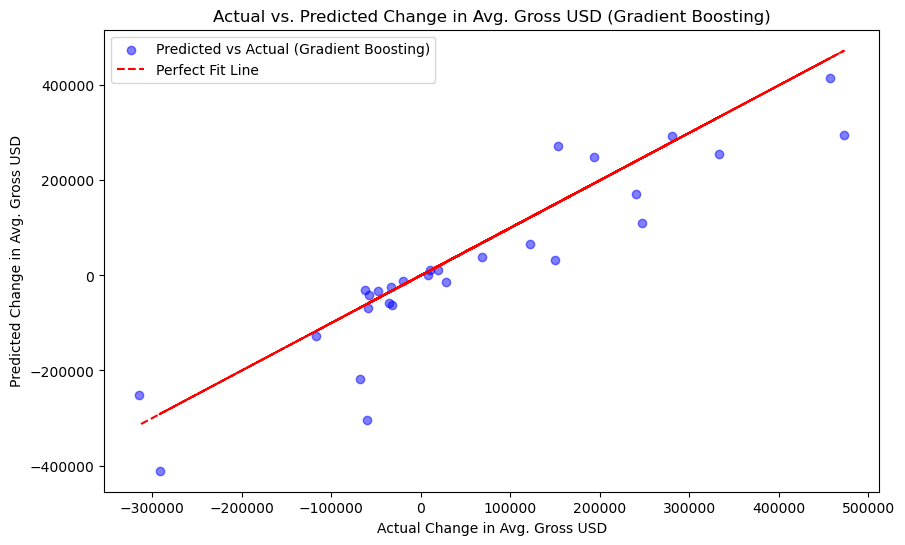

In [83]:
# Plotting the actual vs. predicted changes for the best model (Gradient Boosting in this case)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_gbr, color='blue', alpha=0.5, label='Predicted vs Actual (Gradient Boosting)')
plt.plot(y_test, y_test, color='red', linestyle='--', label='Perfect Fit Line')
plt.xlabel('Actual Change in Avg. Gross USD')
plt.ylabel('Predicted Change in Avg. Gross USD')
plt.title('Actual vs. Predicted Change in Avg. Gross USD (Gradient Boosting)')
plt.legend()
plt.show()